In [1]:
from transformers import pipeline
from sklearn.metrics import confusion_matrix, f1_score
import transformers
from tqdm import tqdm
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

/usr/local/lib64/python3.9/site-packages/torch/cuda/__init__.py:611: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [53]:
def get_sentences():
    df = pd.read_csv(data_location, sep = "\t")
    return df["text"].to_list()

def get_gold_standard():
    # Load in gold standard labels
    with open(majority_labels, "r") as f:
        data = f.readlines()
        data = [ann.strip("\n") for ann in data]
    # Make a list of gold standard but keep those with multiple values as lists
    majority = []
    for item in data:
        # Check if the item contains commas
        if ',' in item:
            # Split the item by commas and add each split item to the flattened list
            majority.append([int(ann) for ann in item.split(',')])
        else:
            # If the item doesn't contain commas, add it directly to the flattened list
            majority.append([int(item)])
    return majority

def predict(sentences):
    pipe = transformers.pipeline(
    'text-classification',
    model=model,
    tokenizer=tokenizer,
    #device=0,
    )
    preds = []
    for text in tqdm(sentences):
        preds.append(pipe(text))
    
    predicted_labels = [i[0]["label"] for i in preds]
    print(f"First few labels: {predicted_labels[0:10]}")
    print(f"Labels: {set(predicted_labels)}")
    return predicted_labels

def labels_to_ids(label_names, predicted_labels):
    predicted_labels = [label_names.index(label) for label in predicted_labels]
    print(f"First few labeld ids: {predicted_labels[:10]}")
    return predicted_labels

def calculate_f1(majority, predicted_labels):
    # Calculate F1 by comparing predictions to majority
    # Resolve ties so that if one of the items is in predictions, use that label. Else use first label.

    winner_preds = []
    winner_labels= []
    for pred, gold in zip(predicted_labels, majority):
        if len(gold) == 1:
            winner_labels.append(gold[0])
            winner_preds.append(pred)
        else:
            labels = [label for label in gold]
            if pred in labels:
                winner_labels.append(pred)
                winner_preds.append(pred)
            else:
                winner_labels.extend(labels)
                for _ in range(len(labels)):
                    winner_preds.append(pred)
    
    print(len(winner_preds))
    print(len(winner_labels))
    # Calculate F1 score
    f1_macro = f1_score(winner_labels, winner_preds, average='macro')
    f1_micro = f1_score(winner_labels, winner_preds, average='micro')
    
    print(f"Macro-average F1 Score: {f1_macro}")
    print(f"Micro-average F1 Score: {f1_micro}")

### This batch of code is for evaluating and plotting the Finparl model against gold standard

In [49]:
# Load fine-tuned model and associated tokenizer

model_name = "finparlmodel_2"
checkpoint = "500"
model_dir = f"../models/{model_name}/checkpoint-{checkpoint}"
model = transformers.AutoModelForSequenceClassification.from_pretrained(model_dir)
tokenizer = transformers.AutoTokenizer.from_pretrained(model_dir)

data_location = "../data/gpt4_annotations/gpt4_annotations_test.tsv"
majority_labels = "../data/human_annotations/annotations3_majority.txt"

# Get numbers
sentences = get_sentences()
gold = get_gold_standard()
predictions = predict(sentences)

100%|██████████| 251/251 [00:22<00:00, 11.25it/s]

First few labels: ['neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'hopeful-optimistic-trust', 'hopeful-optimistic-trust', 'hopeful-optimistic-trust', 'neutral']
Labels: {'fear-worry-distrust', 'hopeful-optimistic-trust', 'joy-success', 'sadness-disappointment', 'neutral', 'love-compliments', 'negative_surprise'}


In [54]:
# Get predictions.
labels = ["neutral", "joy-success", "hopeful-optimistic-trust", "love-compliments", "positive_surprise", "sadness-disappointment", "fear-worry-distrust", "hate-disgust-taunts-mockery", "negative_surprise"]
pred_ids = labels_to_ids(labels, predictions)

# Calculate F1
calculate_f1(gold, pred_ids)

First few labeld ids: [0, 0, 0, 0, 0, 0, 2, 2, 2, 0]
255
255
Macro-average F1 Score: 0.4110171678322454
Micro-average F1 Score: 0.6901960784313725


In [5]:
def flatten_majority(majority):
    # Flatten the majority list
    # Create DataFrames from the label lists
    majority_flattened = []
    for item in majority:
        majority_flattened.extend(item)
    return majority_flattened
    
def get_value_counts(majority_flattened, gpt4_predicted_labels):
    majority_df = pd.DataFrame()
    majority_df["label"] = majority_flattened
    gpt4_pred_df = pd.DataFrame()
    gpt4_pred_df["label"] = gpt4_predicted_labels
    
    # Get normalized value_counts
    majority_valuecounts = majority_df["label"].value_counts(normalize = True).round(2).to_dict()
    gpt4_pred_valuecounts = gpt4_pred_df["label"].value_counts(normalize = True).round(2).to_dict()
    return majority_valuecounts, gpt4_pred_valuecounts

def create_histogram(majority_valuecounts, gpt_pred_valuecounts, save=False):
    # Create a histogram plot using Seaborn
    # Convert dictionaries into a DataFrame
    data = []
    for key in set(majority_valuecounts) | set(gpt_pred_valuecounts):  # Union of keys from both dictionaries
        data.append({'Key': key, 'Value': majority_valuecounts.get(key, 0), 'Source': 'Gold standard'})
        data.append({'Key': key, 'Value': gpt_pred_valuecounts.get(key, 0), 'Source': 'GPT4 model'})
    
    df = pd.DataFrame(data)
    
    # Plotting
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Key', y='Value', hue='Source', data=df, palette = ["goldenrod", "blue"])
    plt.title('Model predictions against gold standard')
    plt.xlabel('Label')
    plt.ylabel('Proportion')
    plt.legend(title=None)
    plt.tight_layout()
    if save:
        plt.savefig("../figures/gpt4_preds_vs_gold")
    plt.show()

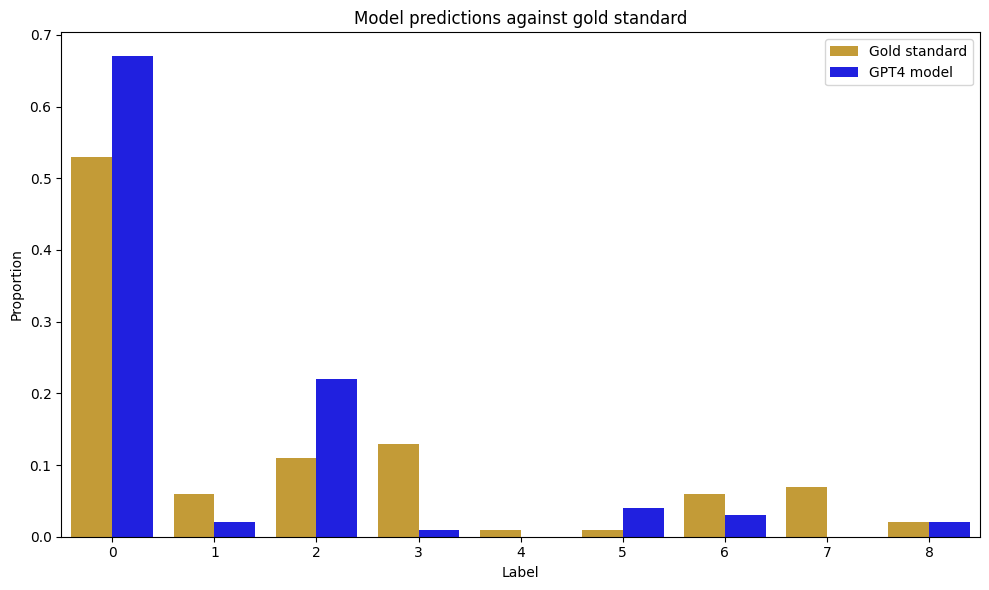

In [6]:
# Get plot
flat_gold = flatten_majority(gold)
gold_vc, gpt4_pred_vc = get_value_counts(flat_gold, pred_ids)
create_histogram(gold_vc,  gpt4_pred_vc, save = False)

### This following batch of code is for evaluating the ME model

In [56]:
model_name = "many_emotions_1_finparl_test"
checkpoint = 20000
model_dir = f"../models/{model_name}/checkpoint-{checkpoint}"
model = transformers.AutoModelForSequenceClassification.from_pretrained(model_dir)
tokenizer = transformers.AutoTokenizer.from_pretrained(model_dir)

data_location = "../data/gpt4_annotations/gpt4_annotations_test.tsv"
majority_labels = "../data/human_annotations/annotations3_majority.txt"

In [57]:
def replace(label):
    if label == 0:
        return 6
    elif label == 1:
        return 2
    elif label == 4:
        return 5
    elif label == 5:
        return 4
    elif label == 6:
        return 1
    elif label == 7:
        return 0
    elif label == 8:
        return 5
    else:
        return label

def harmonize_labels(labels):
    for i, label in enumerate(labels):
        if len(label) == 1:
            labels[i][0] = replace(label[0])
        else:
            for idx, l in enumerate(label):
                labels[i][idx] = replace(l)
    return labels

In [58]:
# Get numbers
sentences = get_sentences()
gold = get_gold_standard()

# We have to turn gold standard labels into ME labels
gold = harmonize_labels(gold)
predictions = predict(sentences)

# Get predictions.
labels = ["anger", "fear", "joy", "love", "sadness", "surprise", "neutral"] # ME labels
pred_ids = labels_to_ids(labels, predictions)
# Calculate F1
calculate_f1(gold, pred_ids)

100%|██████████| 251/251 [00:22<00:00, 11.38it/s]

First few labels: ['neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'joy', 'neutral', 'neutral', 'neutral']
Labels: {'neutral', 'joy'}
First few labeld ids: [6, 6, 6, 6, 6, 6, 2, 6, 6, 6]
263
263
Macro-average F1 Score: 0.13795497580475488
Micro-average F1 Score: 0.5741444866920152


### This batch of code is for evaluating HunEmPoli model

In [59]:
model_name = "hunempoli_model_1"
checkpoint = "500"
model_dir = f"../models/{model_name}/checkpoint-{checkpoint}"
model = transformers.AutoModelForSequenceClassification.from_pretrained(model_dir)
tokenizer = transformers.AutoTokenizer.from_pretrained(model_dir)

data_location = "../data/gpt4_annotations/gpt4_annotations_test.tsv"
majority_labels = "../data/human_annotations/annotations3_majority.txt"

In [61]:
def replace(label):
    if label == 6:
        return 1
    elif label == 5:
        return 2
    elif label == 7:
        return 3
    elif label == 1:
        return 4
    elif label == 2:
        return 5
    elif label in [3,4,8]:
        return None
    else:
        return label

def drop_none(gold):
    out = []
    for label in gold:
        if len(label) == 1:
            if label[0] is not None:
                out.append(label)
        else:
            out_label = []
            for l in label:
                if l is not None:
                    out_label.append(l)
            out.append(out_label)
    return out

In [63]:
# Get numbers
sentences = get_sentences()
gold = get_gold_standard()

# We have to turn gold standard labels into ME labels
gold = harmonize_labels(gold)
gold = drop_none(gold)
predictions = predict(sentences)

# Get predictions.
labels = ["neutral", "fear", "sadness", "anger-digsust", "success-joy", "trust"] # HunEmPoli labels
pred_ids = labels_to_ids(labels, predictions)
# Calculate F1
calculate_f1(gold, pred_ids)

100%|██████████| 251/251 [00:22<00:00, 11.14it/s]

First few labels: ['neutral', 'neutral', 'success-joy', 'anger-digsust', 'anger-digsust', 'neutral', 'success-joy', 'success-joy', 'success-joy', 'success-joy']
Labels: {'trust', 'success-joy', 'anger-digsust', 'sadness', 'neutral'}
First few labeld ids: [0, 0, 4, 3, 3, 0, 4, 4, 4, 4]
234
234
Macro-average F1 Score: 0.18184820668027657
Micro-average F1 Score: 0.2606837606837607
